In [24]:
# Import statements
from brian2 import *

In [25]:
# Parameter definition
# Simulation
duration = 4*second
defaultclock.dt = 1*ms

# Oscillators
seed(42)
N = [2, 5, 10, 25, 50, 100, 150, 200, 250, 500]
sync = 15
f0 = 4 # center freq [Hz]
sigma = 0.5 # normal std offset for omega

# Input stim
dt_stim = 1*ms
t_stim = 2*second
stim_dur = 100*ms
I0 = 200*amp
tv = linspace(0, duration/second, int(duration/(dt_stim))+1)
xstim = 1. * logical_and(tv>t_stim/second, tv<(t_stim+stim_dur)/second)
pulse_train = TimedArray(xstim*amp**-1, dt=dt_stim)

In [26]:
# Equations
# Kuramoto oscillators
kuramoto_eqs_stim = '''
    dTheta/dt = ((omega + (kN * PIF) - I_stim*X*sin(Theta - pi/2)) * second**-1) : 1
    PIF = .5 * (sin(ThetaPreInput - Theta)) : 1
    ThetaPreInput : 1
    omega : 1 (constant)
    kN : 1 (shared)         # k/N ratio, affects sync.
    I_stim : amp (shared)   # this is the input gain, affects the phase reset aggressiveness
    X = pulse_train(t) : amp**-1 (shared)
'''

# synapses
syn_kuramoto_eqs = '''
    ThetaPreInput_post = Theta_pre
'''

# Order parameter group calculation equations
pop_avg_eqs = '''
    x : 1
    y : 1
    coherence = sqrt(x**2 + y**2) : 1
    phase = arctan(y/x) + int(x<0 and y>0)*pi - int(x<0 and y<0)*pi: 1
    rhythm = coherence * sin(phase) : 1
    test = y : 1
    rhythm_pos = coherence * (sin(phase)+1)/2 : 1
    rhythm_rect = rhythm_pos*nA : amp
'''

syn_avg_eqs = '''
    x_post = cos(Theta_pre)/N_incoming : 1 (summed)
    y_post = sin(Theta_pre)/N_incoming : 1 (summed)
'''

In [27]:
# Make the necessary groups
# Oscillators
N_tot = sum(N)
G_K = NeuronGroup(N_tot,
    model=kuramoto_eqs_stim,
    threshold='True',
    method='euler',
    name='Kuramoto_oscillators_N_%d' % N_tot)
#G_K.Theta = '2*pi*rand()' # uniform U~[0,2π]
#G_K.omega = '2*pi*(f0+sigma*randn())' # normal N~(f0,σ)
theta0 = 2*pi*rand(N_tot) # uniform U~[0,2π]
omega0 = 2*pi*(f0 + sigma*randn(N_tot)) # ~N(2πf0,σ)
G_K.Theta = theta0
G_K.omega = omega0
G_K.kN = sync
G_K.I_stim= I0

# Kuramoto order parameter group
G_pop_avg = NeuronGroup(len(N),
    model=pop_avg_eqs,
    #method='euler',
    name='Kuramoto_averaging')

print('General groups: done')

General groups: done


In [28]:
# Define subgroups
G_all = []
syn_all = []

kuramoto_mon_all = []
order_param_mon_all = []

idx0 = 0
idx1 = 0

for gnum in range(len(N)):
    N_curr = N[gnum]
    
    idx0 = idx1
    idx1 += N_curr
    
    # Subgroups
    G_K_curr = G_K[idx0:idx1]
    
    G_pop_avg_curr = G_pop_avg[gnum]
    r0 = 1/N_curr * sum(exp(1j*G_K_curr.Theta))
    G_pop_avg_curr.x = real(r0)  # avoid division by zero
    G_pop_avg_curr.y = imag(r0)
    
    G_all.append(G_K_curr)
    G_all.append(G_pop_avg_curr)
    
    
    # Synapses
    syn_kuramoto_curr =  Synapses(G_K_curr, G_K_curr, on_pre=syn_kuramoto_eqs, method='euler', name='Kuramoto_intra_{0}'.format(gnum))
    syn_kuramoto_curr.connect(condition='i!=j')

    syn_avg_curr = Synapses(G_K_curr, G_pop_avg_curr, syn_avg_eqs, name='Kuramoto_avg_{0}'.format(gnum))
    syn_avg_curr.connect()
    
    syn_all.append(syn_kuramoto_curr)
    syn_all.append(syn_avg_curr)

    
    # Monitors
    kuramoto_mon_curr = StateMonitor(G_K_curr, ['Theta'], record=True)
    order_param_mon_curr = StateMonitor(G_pop_avg_curr, ['coherence', 'test', 'phase', 'rhythm', 'rhythm_pos', 'rhythm_rect'], record=True)
    
    kuramoto_mon_all.append(kuramoto_mon_curr)
    order_param_mon_all.append(order_param_mon_curr)
    
print('Subgroups: done')

Subgroups: done


In [29]:
# Network
net = Network()
net.add(G_K)
net.add(G_pop_avg)
net.add(G_all)
net.add(syn_all)
net.add(kuramoto_mon_all)
net.add(order_param_mon_all)

In [30]:
# Run the simulation
net.run(duration, report='text', report_period=10*second, profile=True)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the 

Starting simulation at t=0. s for a duration of 4. s
4. s (100%) simulated in 4s


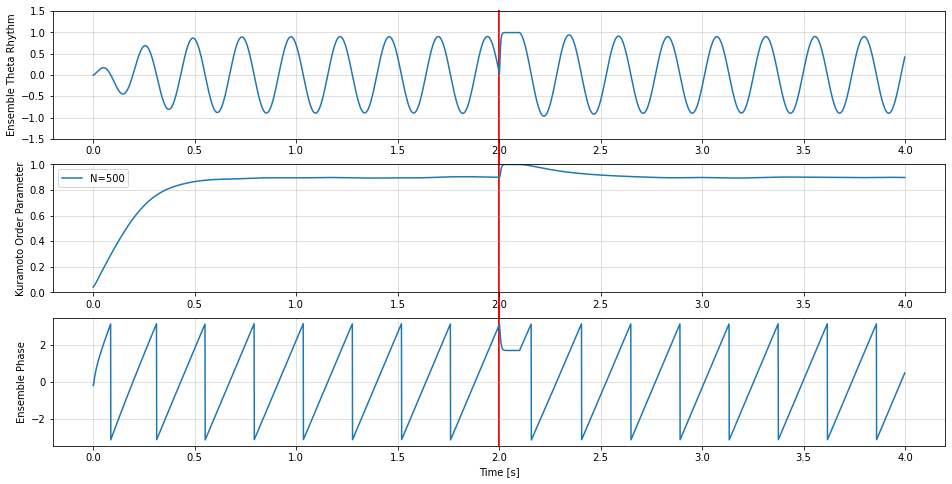

In [33]:
# plot the results
fig, axs = subplots(3,1)
fig.set_figheight(8)
fig.set_figwidth(16)

# for gnum in range(len(N)):
axs[0].plot(order_param_mon_all[-1].t/second, order_param_mon_all[-1].rhythm[0], '-', label='N=%d' % N[gnum])
axs[1].plot(order_param_mon_all[-1].t/second, order_param_mon_all[-1].coherence[0], '-', label='N=%d' % N[gnum])
axs[2].plot(order_param_mon_all[-1].t/second, order_param_mon_all[-1].phase[0], '-', label='N=%d'%N[gnum])    

# Imaginary part of order parameter 1/N Sum ( e^j*theta ) = 1/N Sum Imag{e^j*theta} = 1/N Sum sin(theta)
# This is the normalized (0-1) summed output sine wave!


# labels
axs[0].set_ylabel("Ensemble Theta Rhythm")
axs[1].set_ylabel("Kuramoto Order Parameter")
axs[2].set_ylabel("Ensemble Phase")
axs[2].set_xlabel("Time [s]")
axs[0].set_ylim([-1.5,1.5])
axs[1].set_ylim([0,1])
axs[0].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[1].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[2].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=True)

# make things pretty
#axs[0].legend()
axs[0].grid(linestyle='-',alpha=0.5)
axs[1].legend()
axs[1].grid(linestyle='-',alpha=0.5)
#axs[2].legend()
axs[2].grid(linestyle='-',alpha=0.5)

# show
fig.savefig('sample.png', facecolor='white', transparent=False)
show()


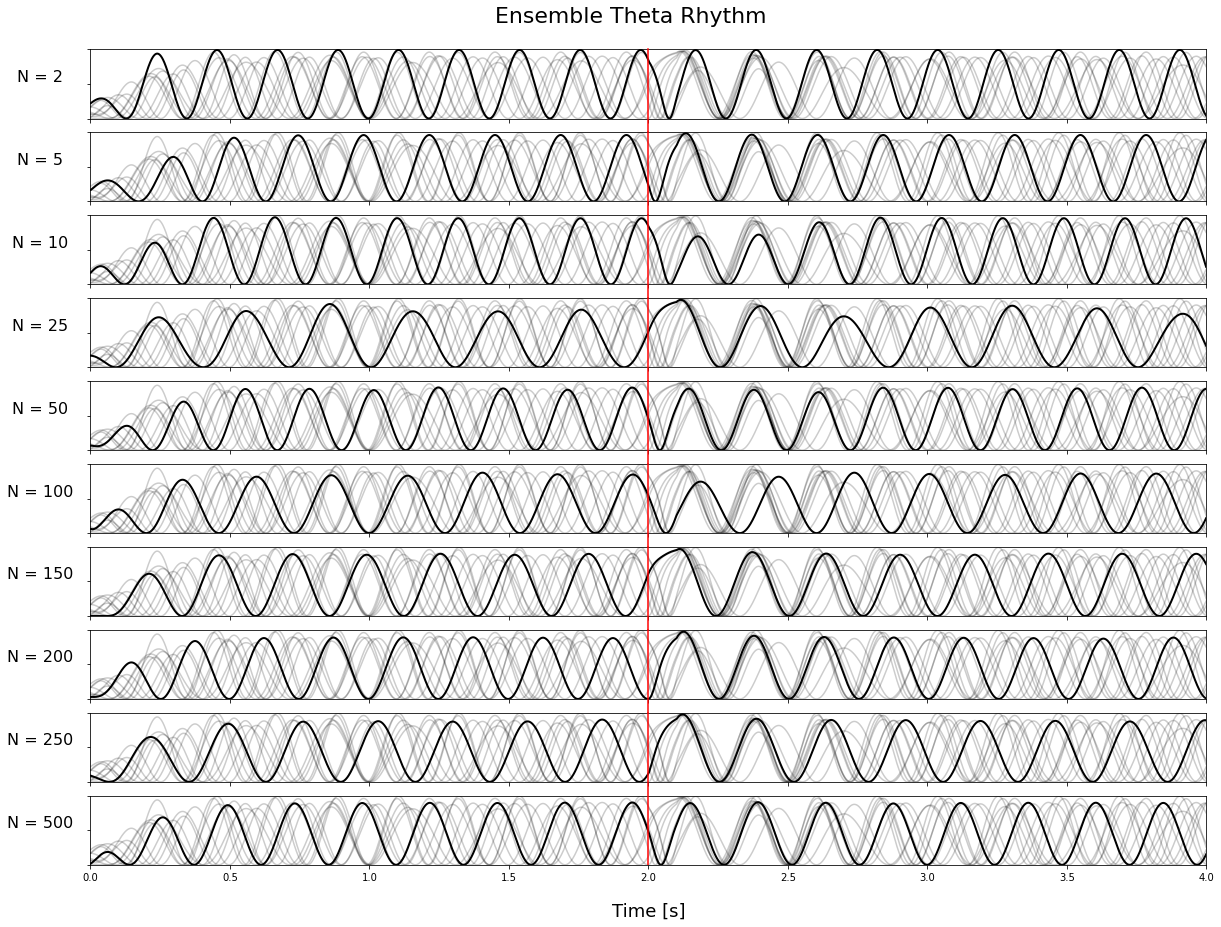

In [89]:
# Avoiding chartjunk [Bottom subplot]
fig, axs = subplots(len(N), figsize=(20,15))

fig.suptitle('Ensemble Theta Rhythm', fontsize=22, y=0.92)

for axnum in range(len(N)):
    for gnum in range(len(N)):
        if axnum == gnum:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].rhythm_pos[0], ls='-', linewidth=2, c='k', alpha=1, zorder=3)
        else:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].rhythm_pos[0], ls='-', c='k', alpha=0.2, zorder=2)

    axs[axnum].set_ylim([0,1])
    axs[axnum].set_xlim([0,duration])
    axs[axnum].tick_params(axis='both',       # changes apply to both axes
                           which='both',      # both major and minor ticks are affected
                           bottom=True,       # ticks along the bottom edge are on
                           top=False,         # ticks along the top edge are on
                           right=False, 
                           left=True, 
                           labelbottom=False, # labels along the bottom edge are off
                           labelleft=False)
    axs[axnum].set_ylabel('N = %d' % N[axnum], fontsize=16, rotation=0, labelpad=50)
    vline = axs[axnum].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=1.5, zorder=3, clip_on=False)

axs[axnum].set_xlabel('Time [s]', fontsize=18, labelpad=20)
axs[axnum].tick_params(axis='x',
                       which='both',
                       bottom=True,
                       top=False,
                       right=False,
                       left=True,
                       labelbottom=True,
                       labelleft=False)
# clip the last vline
vline.set(clip_on=True)

fig.savefig('Ensemble Theta Rhythm.png', facecolor='white', transparent=False)
plt.show()

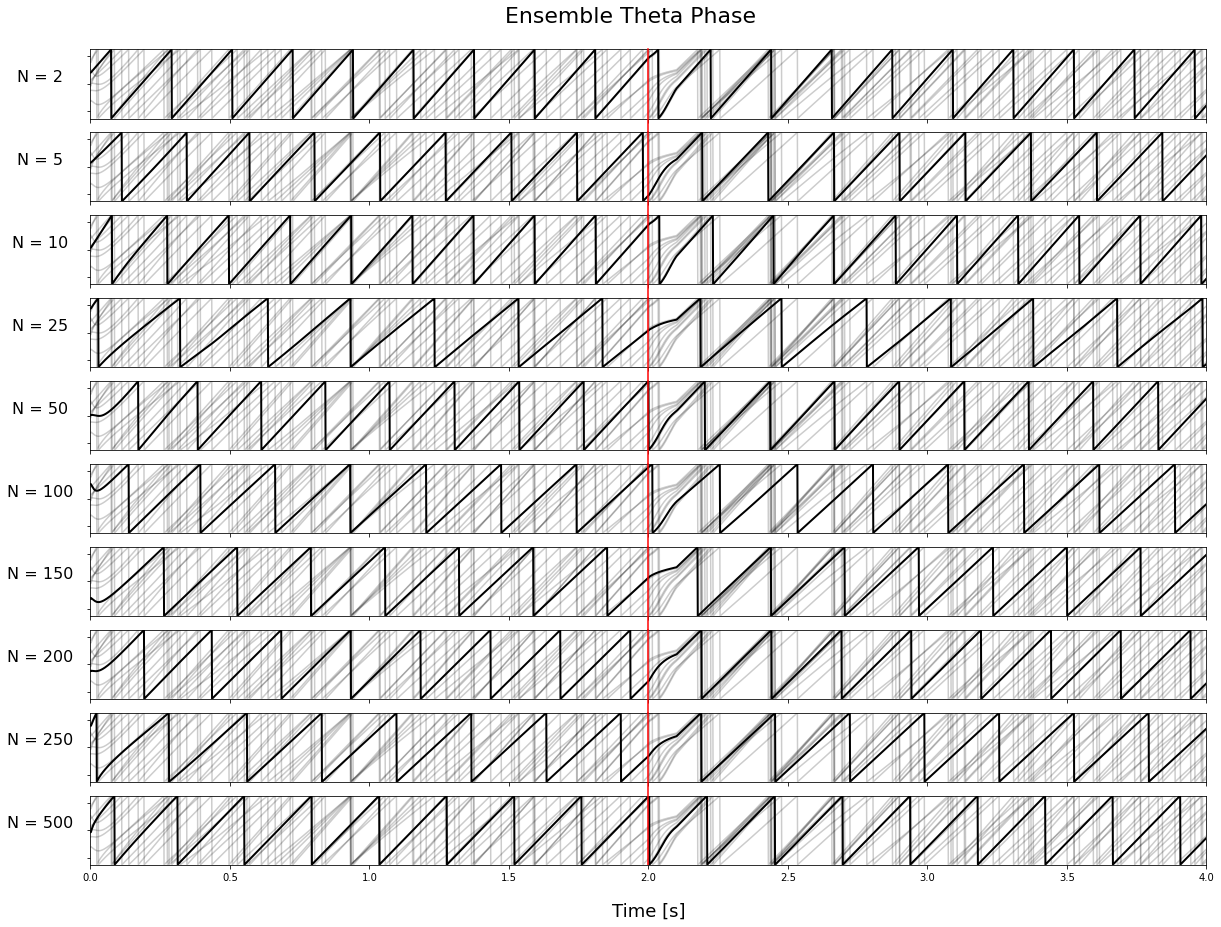

In [85]:
# Avoiding chartjunk [Bottom subplot]
fig, axs = subplots(len(N), figsize=(20,15))

fig.suptitle('Ensemble Theta Phase', fontsize=22, y=0.92)

for axnum in range(len(N)):
    for gnum in range(len(N)):
        if axnum == gnum:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].phase[0], ls='-', linewidth=2, c='k', alpha=1, zorder=3)
        else:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].phase[0], ls='-', c='k', alpha=0.2, zorder=2)

    axs[axnum].set_ylim([-pi,pi])
    axs[axnum].set_xlim([0,duration])
    axs[axnum].tick_params(axis='both',       # changes apply to both axes
                           which='both',      # both major and minor ticks are affected
                           bottom=True,       # ticks along the bottom edge are on
                           top=False,         # ticks along the top edge are on
                           right=False, 
                           left=True, 
                           labelbottom=False, # labels along the bottom edge are off
                           labelleft=False)
    axs[axnum].set_ylabel('N = %d' % N[axnum], fontsize=16, rotation=0, labelpad=50)
    vline = axs[axnum].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=1.5, zorder=3, clip_on=False)

axs[axnum].set_xlabel('Time [s]', fontsize=18, labelpad=20)
axs[axnum].tick_params(axis='x',
                       which='both',
                       bottom=True,
                       top=False,
                       right=False,
                       left=True,
                       labelbottom=True,
                       labelleft=False)
# clip the last vline
vline.set(clip_on=True)

fig.savefig('Ensemble Theta Phase.png', facecolor='white', transparent=False)
plt.show()

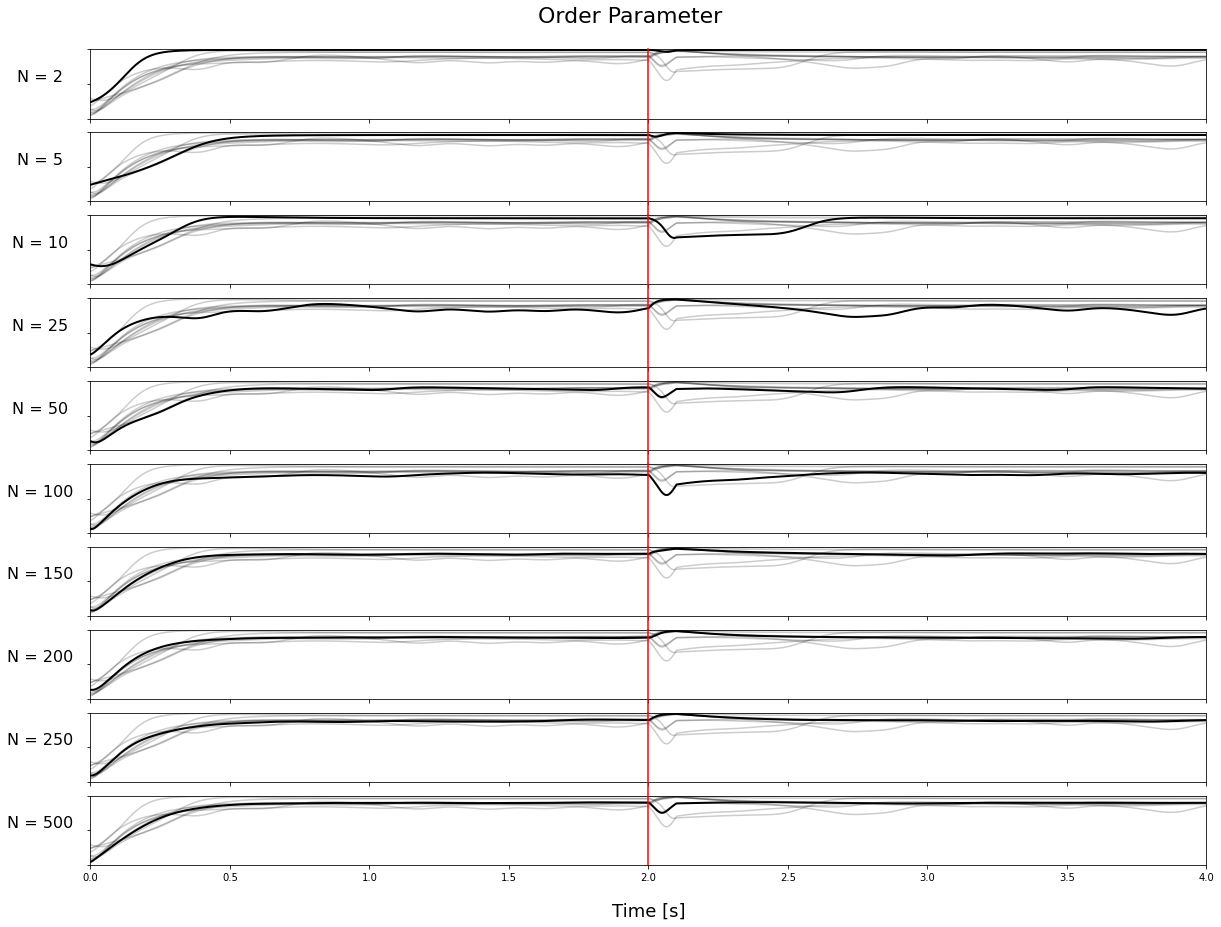

In [87]:
# Avoiding chartjunk [Mid subplot]
fig, axs = subplots(len(N), figsize=(20,15))

fig.suptitle('Order Parameter', fontsize=22, y=0.92)

for axnum in range(len(N)):
    for gnum in range(len(N)):
        if axnum == gnum:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].coherence[0], ls='-', linewidth=2, c='k', alpha=1, zorder=3)
        else:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].coherence[0], ls='-', c='k', alpha=0.2, zorder=2)

    axs[axnum].set_ylim([0,1])
    axs[axnum].set_xlim([0,duration])
    axs[axnum].tick_params(axis='both',       # changes apply to both axes
                           which='both',      # both major and minor ticks are affected
                           bottom=True,       # ticks along the bottom edge are on
                           top=False,         # ticks along the top edge are on
                           right=False, 
                           left=True, 
                           labelbottom=False, # labels along the bottom edge are off
                           labelleft=False)
    axs[axnum].set_ylabel('N = %d' % N[axnum], fontsize=16, rotation=0, labelpad=50)
    vline = axs[axnum].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=1.5, zorder=3, clip_on=False)

axs[axnum].set_xlabel('Time [s]', fontsize=18, labelpad=20)
axs[axnum].tick_params(axis='x',
                       which='both',
                       bottom=True,
                       top=False,
                       right=False,
                       left=True,
                       labelbottom=True,
                       labelleft=False)
# clip the last vline
vline.set(clip_on=True)

fig.savefig('Order Parameter.png', facecolor='white', transparent=False)
plt.show()